In [1]:
import os
#os.chdir("/content/drive/My Drive/4年/浅井さん修論/paper")
os.chdir("D:\AsaiProgram\current")

In [51]:
# config
cfg = {
    "epochs": 25,
    "steps_per_epoch": 100000,
    "batch_size": 128,

    "height": 90,
    "width": 320,
    "crop_lower": 50,
    "crop_upper": 90,

    "steering_adjustment": 0.065

}

https://github.com/mcarilli/CarND-Behavioral-Cloning-P3-Solution

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

has 203 outliers


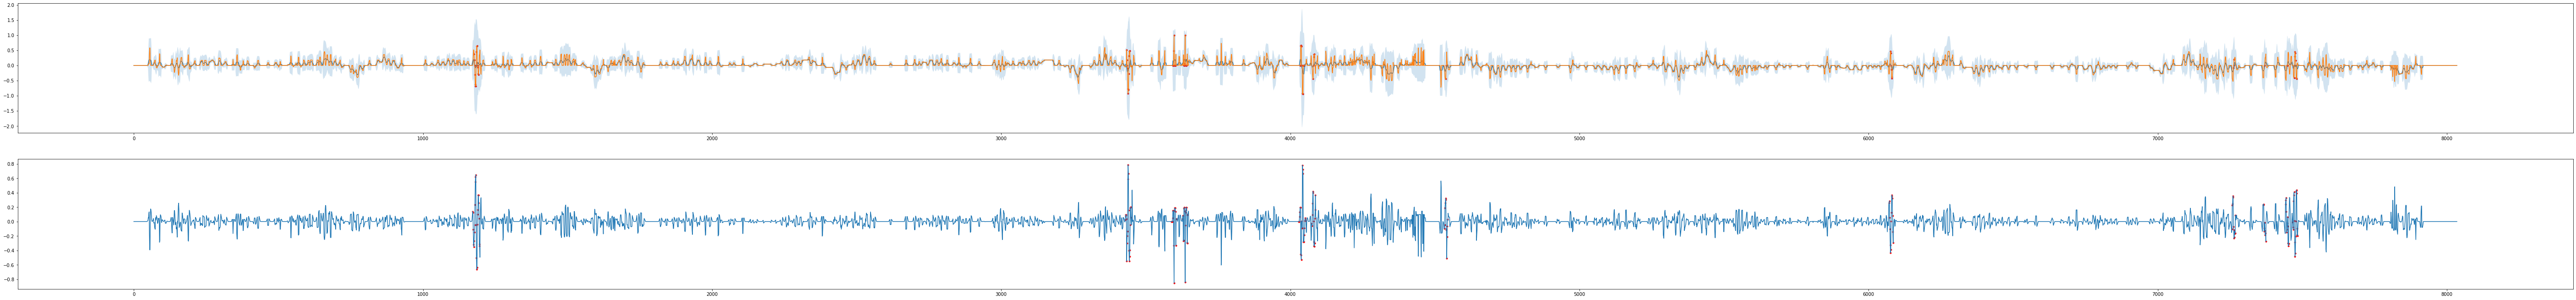

num data 8036
num data 7833
tensor([-0.0613])


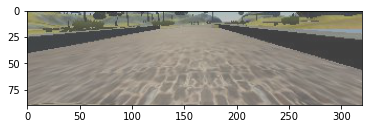

In [60]:
# load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math
import random

def remove_outliers(df, threshold=0.3, method="ma", span=10, frames=5, manual_index=[], verbose=True):
    """
    df: driving_log.csv
    threshold: この値より移動標準偏差が大きいと外れ値と認定する閾値
    method: 移動平均、標準偏差の計算方法 
    span: 移動平均の計算期間
    frames: 外れ値と認定された前後のframesの数だけも外れ値認定する
    verbose: 外れ値となったところを表示するかどうか
    """
    if method == "ma":
        ma = df["steering"].rolling(window=span, center=True, min_periods=1).mean()
        ms = df["steering"].rolling(window=span, center=True, min_periods=1).std()
    else:
        ma = df["steering"].ewm(span=span).mean()
        ms = df["steering"].ewm(span=span).std()

    outliers =  df["steering"][np.abs(ms) > threshold] 
    outliers_index = outliers.index
    # 外れ値と認定された周辺を学習させるのは適切ではないだろうから除外
    outliers_index = np.unique([outliers_index.values + i for i in range(-frames, frames)])
    print(f"has {outliers_index.shape[0]} outliers")

    if verbose:
        fig = plt.figure(figsize=(100, 24))
        ax1 = fig.add_subplot(4, 1, 1)
        ax1.scatter(outliers.index, outliers, marker=".", color="red")
        ax1.plot(ma)
        ax1.plot(df["steering"])
        ax1.fill_between(ma.index,
                            ma - ms * 3 ,
                            ma + ms * 3,
                            alpha=0.2)
        ax2 = fig.add_subplot(4, 1, 2)
        diff = ma - df["steering"]
        ax2.scatter(outliers_index, diff.iloc[outliers_index], marker=".", color="red")
        ax2.plot(ma - df["steering"])
        plt.show()
    print(f"num data {df.shape[0]}")
    new_df = df.drop(outliers_index)
    new_df = new_df.reset_index(drop=True)
    print(f"num data {new_df.shape[0]}")
    return new_df



class MyDataset(Dataset):
    def __init__(self, data, transform=None, root="./data/"):
        self.driving_data = data
        self.transform = transform 
        self.root = root
        
    def __len__(self):
        return self.driving_data.shape[0]

    def __getitem__(self, idx):
        ith_data = self.driving_data.iloc[idx]
        rand = np.random.uniform()
        steering = ith_data["steering"].astype("float32")
        if np.abs(steering) > 1.15:
            image_path = self.root + ith_data["center"]
            steering = np.array([steering])
        else:
            if rand < 0.4:
                image_path = self.root + ith_data["center"]
                steering = np.array([ith_data["steering"].astype("float32")]) 
            elif rand < 0.7:
                image_path = self.root + ith_data["left"]
                steering = np.array([ith_data["steering"].astype("float32") + cfg["steering_adjustment"]]) 
            else:
                image_path = self.root + ith_data["right"]
                steering = np.array([ith_data["steering"].astype("float32") - cfg["steering_adjustment"]]) 
        # steering = torch.Tensor([ith_data["steering"].astype("float32")])                 
        image = Image.open(image_path)
        

        if transform:
            image, steering =  transform(image, steering)
        return {"image": image, "steering": torch.Tensor(steering)}

class MyTransform(object):
    def __init__(self, train=True):
        self.random_horizontal_flip = transforms.RandomHorizontalFlip()
        self.resize = transforms.Resize((cfg["height"], cfg["width"]))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
        self.train = train
        
    def __call__(self, image, steering):
        # plt.imshow(image)
        # plt.show()
        image = transforms.functional.crop(image, cfg["crop_lower"], 0, cfg["crop_upper"], image.width)
        # plt.imshow(image)
        # plt.show()
        if self.train:
            rand = np.random.uniform()
            if rand < 0.5:
                image = transforms.functional.hflip(image)
                steering = -1*steering
            steering = steering + np.random.randn()*steering*0.1
        # image = self.resize(image)
        image = self.to_tensor(image)
        image = self.normalize(image)
        return image, steering

transform = MyTransform(True)
data = remove_outliers(pd.read_csv("./data/driving_log.csv"))
# data, _ = load_data("./data/driving_log.csv")
dataset = MyDataset(data, transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)
sample_data = next(iter(dataloader))
plt.imshow((sample_data["image"][0]*0.5+0.5).numpy().transpose(1,2,0))
print(sample_data["steering"][0])

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2, padding=0),  # 24x43x158
            nn.ReLU(),
            nn.Conv2d(24, 36, 5, stride=2, padding=0),  # 36x20x77
            nn.ReLU(),
            nn.Conv2d(36, 48, 5, stride=2, padding=0),  # 48x8x37
            nn.ReLU(),
            nn.Conv2d(48, 64, 3, stride=1, padding=0),  # 64x6x35
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),  # 64x4x33
            nn.ReLU()
        )
        self.regressor = nn.Sequential(
            nn.Linear(64*4*33, 100),
            nn.Dropout(),
            nn.Linear(100, 50),
            # nn.Dropout(),
            nn.Linear(50, 10),
            # nn.Dropout(),
            nn.Linear(10, 1)
            # nn.Linear(10, 1)
        )

        # self.conv1 = nn.Conv2d(3, 24, 5, stride=2, padding=0)  #31x98
        # self.bn1 = nn.BatchNorm2d(24)
        # self.conv2 = nn.Conv2d(24, 36, 5, stride=2, padding=0)  #14x47
        # self.bn2 = nn.BatchNorm2d(36)
        # self.conv3 = nn.Conv2d(36, 48, 5, stride=2, padding=0)  #5x22
        # self.bn3 = nn.BatchNorm2d(48)
        # self.conv4 = nn.Conv2d(48, 64, 3, stride=1, padding=0)  #3x20
        # self.bn4 = nn.BatchNorm2d(64)
        # self.conv5 = nn.Conv2d(64, 64, 3, stride=1, padding=0)  #1x18
        # self.bn5 = nn.BatchNorm2d(64)

        # self.flatten = nn.Flatten()

        # self.fc1 = nn.Linear(64*1*18, 100)
        # self.bn6 = nn.BatchNorm1d(100)
        # self.fc2 = nn.Linear(100, 50)
        # self.bn7 = nn.BatchNorm1d(50)
        # self.fc3 = nn.Linear(50, 10)
        # self.bn8 = nn.BatchNorm1d(10)
        # self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.regressor(x)

        # x = F.elu(self.conv1(x))
        # x = F.elu(self.conv2(x))
        # x = F.elu(self.conv3(x))
        # x = F.elu(self.conv4(x))
        # x = F.elu(self.conv5(x))
        # x = self.flatten(x)
        # x = F.elu(self.fc1(x))
        # x = F.elu(self.fc2(x))
        # x = F.elu(self.fc3(x))
        # x = self.fc4(x)
        return x


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

class Trainer:
    def __init__(self, root):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net = Net().to(self.device)
        print(self.net)
        self.optimizer = optim.Adam(self.net.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-3)
        #self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=cfg["batch_size"]//2, gamma=0.5)
        # self.train_data, self.val_data = load_data(root + "driving_log.csv")
        self.data = pd.read_csv(root + "driving_log.csv")
        self.additional_data = pd.read_csv("./additional_data2/driving_log.csv")
        self.curve_data = pd.read_csv("./curve_data/driving_log.csv")

        self.data = remove_outliers(self.data)
        self.additional_data = remove_outliers(self.additional_data)
        self.curve_data = remove_outliers(self.curve_data)

        self.data = pd.concat([self.data, self.additional_data, self.curve_data])
        self.root = root

        self.train_data, self.val_data = train_test_split(self.data)

        self.history = {"loss": [], "val_loss": [], "rmse": [], "val_rmse": []}

    def train(self):
        train_transform = MyTransform()
        val_transform = MyTransform(False)

        train_dataset = MyDataset(self.train_data, train_transform, root=self.root)
        train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True, drop_last=True)

        val_dataset = MyDataset(self.val_data, val_transform, root=self.root)
        val_loader = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False)

        loss_fn = nn.MSELoss()

        for epoch in range(cfg["epochs"]):
            self.net.train()
            losses = []
            start = time.time()
            cnt = 0
            for i, train_data in enumerate(train_loader):
                X = train_data["image"].to(self.device)
                y = train_data["steering"].to(self.device)
                pred = self.net(X)
                loss = loss_fn(pred, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())
                cnt += 1
                if i >= cfg["steps_per_epoch"]:
                    break

            self.net.eval()
            val_losses = []
            with torch.no_grad():
                for i, val_data in enumerate(val_loader):
                    X = val_data["image"].to(self.device)
                    y = val_data["steering"].to(self.device)
                    pred = self.net(X)
                    loss = loss_fn(pred, y)
                    val_losses.append(loss.item())

            #self.scheduler.step()
            self.history["loss"].append(np.mean(losses))
            self.history["val_loss"].append(np.mean(val_losses))
            self.history["rmse"].append(np.sqrt(self.history["loss"][-1]))
            self.history["val_rmse"].append(np.sqrt(self.history["val_loss"][-1]))

            print("{} epoch finished after {:.2f}s,{}steps for training, loss {:.4f}, val_loss {:.4f}, rmse {:.4f}, val_rmse {:.4f}".format(
                epoch,
                time.time() - start,
                cnt,
                self.history["loss"][-1],
                self.history["val_loss"][-1],
                self.history["rmse"][-1],
                self.history["val_rmse"][-1]
            ))
    def show_loss(self):
        fig = plt.figure(figsize=(6, 6))
        ax1 = fig.add_subplot(2, 1, 1)
        ax1.plot(self.history["loss"], label="train")
        ax1.plot(self.history["val_loss"], label="val")
        ax1.set_title("losses")
        ax1.legend()

        ax2 = fig.add_subplot(2, 1, 2)
        ax2.plot(self.history["rmse"], label="train")
        ax2.plot(self.history["val_rmse"], label="val")
        ax2.set_title("RMSEs")
        ax2.legend()

        plt.show()

    def save_weight(self, path):
        torch.save(self.net.state_dict(), path)
        print("model saved at {}".format(path))
        pd.DataFrame(self.history).to_csv(path[:-4] + ".csv")

    def load_weights(self, path):
        self.net.load_state_dict(torch.load(path))
        print("wieght")

    def show_diff_and_dist(self):
        transform = MyTransform(False)
        dataset = MyDataset(self.val_data, transform, root=self.root)
        loader = DataLoader(dataset, batch_size=cfg["batch_size"], shuffle=False)
        self.net.eval()
        with torch.no_grad():
            driving_data = next(iter(loader))
            image = driving_data["image"].to(self.device)
            steering = driving_data["steering"].to(self.device)
            pred = self.net(image)
        steering = steering.view(-1).cpu()
        pred = pred.view(-1).cpu()
        fig = plt.figure(figsize=(20, 6))
        ax1 = fig.add_subplot(2, 1, 1)
        ax1.plot(steering, label="steering")
        ax1.plot(pred, label="prediction")
        ax1.legend()

        ax2 = fig.add_subplot(2, 1, 2)
        ax2.plot(pred - steering, label="difference")
        ax2.legend()

        plt.show()

        sns.distplot(steering, label="steering", bins=50)
        sns.distplot(pred, label="prediction", bins=50)
        plt.legend()
        plt.xlim(-0.5, 0.5)

        plt.show()
    
    def show_images_predicted(self):
        fig = plt.figure(figsize=(20, 10))
        axs = []
        transform = MyTransform(True)
        dataset = MyDataset(self.val_data, transform, root=self.root)
        data_loader = DataLoader(dataset, batch_size=16, shuffle=True)
        data = next(iter(data_loader))
        image = data["image"].to(self.device)
        target = data["steering"].view(-1)
        self.net.eval()
        with torch.no_grad():
            prediction = self.net(image).view(-1)

        count = 0
        for i in range(4):
            for j in range(4):
                axs.append(fig.add_subplot(4, 4, count+1))
                axs[-1].imshow((image[count]*0.5 + 0.5).cpu().numpy().transpose(1, 2, 0))
                axs[-1].set_title("predicted: {:.4f} target: {:.4f}".format(prediction[count].item(), target[count].item()))
                count += 1
        plt.show()



Net(
  (features): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
  )
  (regressor): Sequential(
    (0): Linear(in_features=8448, out_features=100, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)
has 203 outliers


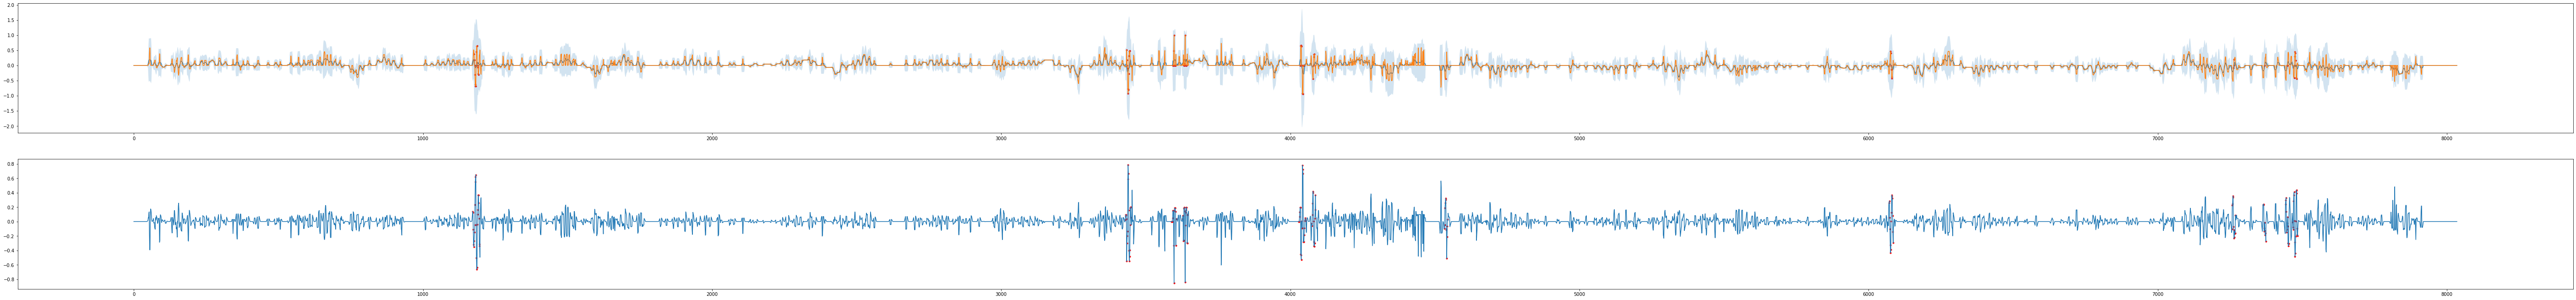

num data 8036
num data 7833
has 0 outliers


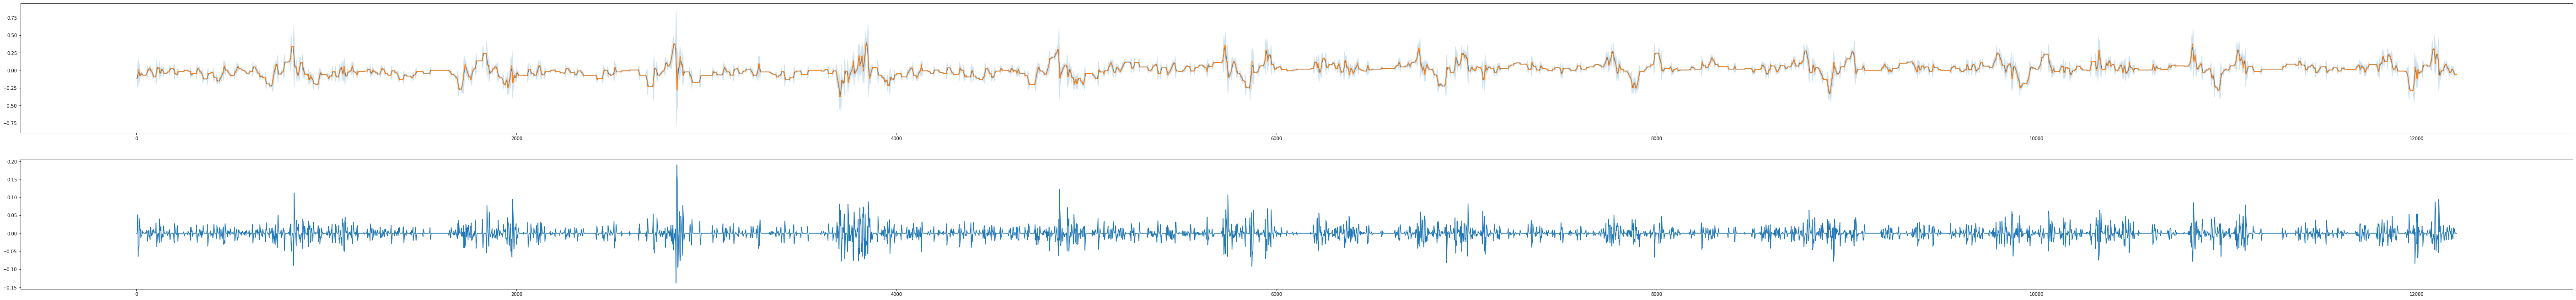

num data 12211
num data 12211
has 0 outliers


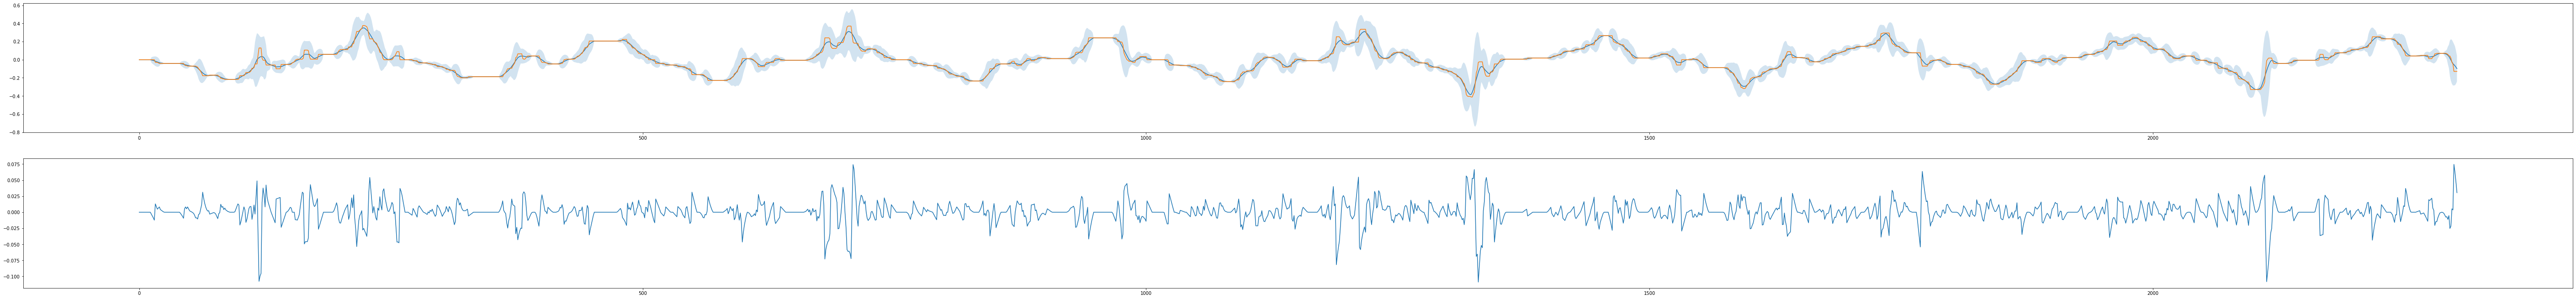

num data 2303
num data 2303
0 epoch finished after 148.65s,130steps for training, loss 0.0156, val_loss 0.0139, rmse 0.1250, val_rmse 0.1180
1 epoch finished after 149.64s,130steps for training, loss 0.0109, val_loss 0.0077, rmse 0.1045, val_rmse 0.0880
2 epoch finished after 149.89s,130steps for training, loss 0.0076, val_loss 0.0070, rmse 0.0871, val_rmse 0.0836
3 epoch finished after 148.33s,130steps for training, loss 0.0074, val_loss 0.0066, rmse 0.0859, val_rmse 0.0810
4 epoch finished after 146.65s,130steps for training, loss 0.0068, val_loss 0.0067, rmse 0.0827, val_rmse 0.0816
5 epoch finished after 145.67s,130steps for training, loss 0.0066, val_loss 0.0061, rmse 0.0813, val_rmse 0.0781
6 epoch finished after 139.99s,130steps for training, loss 0.0065, val_loss 0.0062, rmse 0.0808, val_rmse 0.0789
7 epoch finished after 138.06s,130steps for training, loss 0.0062, val_loss 0.0059, rmse 0.0789, val_rmse 0.0767
8 epoch finished after 134.92s,130steps for training, loss 0.0062, v

In [63]:
trainer = Trainer("./data/")
trainer.train()

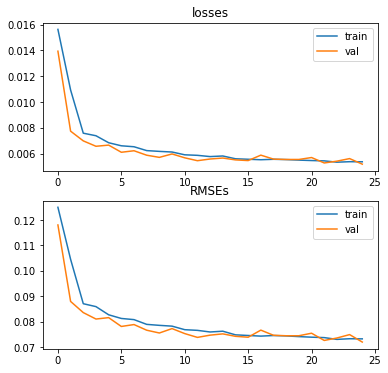

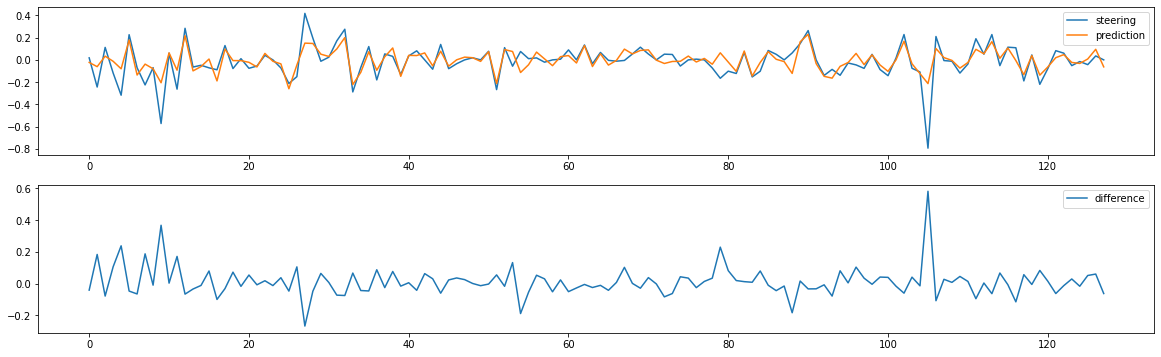

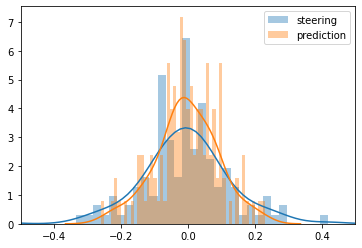

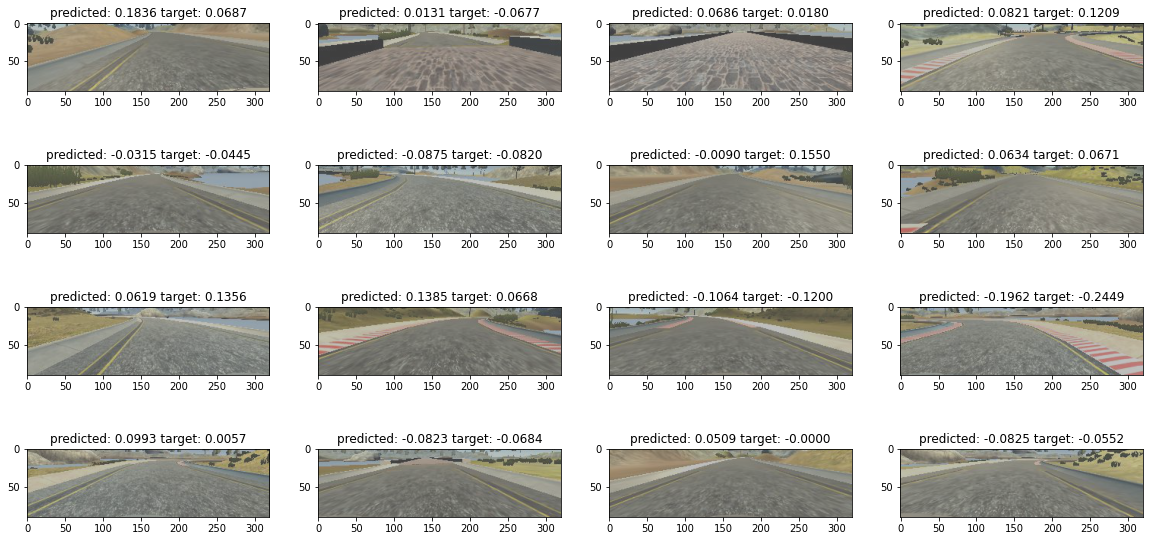

In [64]:
trainer.show_loss()
trainer.show_diff_and_dist()
trainer.show_images_predicted()

In [65]:
trainer.save_weight("nvidia_model/weights_github2_13_curve.pth")

model saved at nvidia_model/weights_github2_13_curve.pth


In [66]:

import base64
import numpy as np
import socketio
import eventlet
import eventlet.wsgi
import time
from PIL import Image
from PIL import ImageOps
from flask import Flask, render_template
from io import BytesIO
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import time

import pyautogui
import keyboard

sio = socketio.Server()

net = None


@sio.on("telemetry")
def telemetry(sid, data):

    image_string = data["image"]
    steering_angle = float(data["steering_angle"])/25  # -25~ 25の範囲だから/25する

    speed = data["speed"]
    throttle = 0.20
    steering_angle, throttle, brake  = manual_control(steering_angle)
    if steering_angle is not None:
        send_control(steering_angle, throttle, brake)
        print("steering:{:.4f}  throttle:{}  speed:{}".format(steering_angle, throttle, speed))
    else:
        image = Image.open(BytesIO(base64.b64decode(image_string))) 

        image , _ = transform(image, 0.0)
        image = torch.unsqueeze(image, 0)  # batch次元を増やす
        steering_angle = net(image)

        print("steering:{:.4f}  throttle:{}  speed:{}".format(steering_angle.item(), throttle, speed))

        send_control(steering_angle.item(), throttle)
        # sio.emit('manual', data={}, skip_sid=True)


@sio.on('connect')
def connect(sid, environ):
    print("connect ", sid)
    print("environ", environ)
    send_control(0, 0) 

def send_control(steering_angle, throttle, brake=0.0, speed=20.0):
    sio.emit("steer", data={
        'steering_angle': steering_angle.__str__(),
        'throttle': throttle.__str__(),
        "brake": brake.__str__()
    }, skip_sid=True)

def press_escape():
    pyautogui.press("esc")
    time.sleep(1.0)

def click():
    pyautogui.click()

def manual_control(steering):
    if keyboard.is_pressed("down"):
        if keyboard.is_pressed("left"):
            return steering - 0.05, -1.0, 1.0
        elif keyboard.is_pressed("right"):
            return steering + 0.05, -1.0, 1.0
        else:
            return 0.0, -1.0, 1.0
    elif keyboard.is_pressed("left"):
        return steering - 0.05, 0.20, 0.0
    elif keyboard.is_pressed("right"):
        return steering + 0.05, 0.20, 0.0
    elif keyboard.is_pressed("up"):
        return steering*0.25, 1.0, 0.0
    return None, 0.20, None


if __name__ == "__main__":
    net = Net().eval()
    net.load_state_dict(torch.load("nvidia_model/weights_github2_13_curve.pth"))
    transform = MyTransform(False)

    app = Flask(__name__)
    app = socketio.Middleware(sio, app)
    # deploy as an eventlet WSGI server
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app, debug=True) #133.68.111.22

(20968) wsgi starting up on http://0.0.0.0:4567
(20968) accepted ('127.0.0.1', 56270)


connect  75a15dbb2960441b93d42658d07f64d2
environ {'wsgi.errors': <ipykernel.iostream.OutStream object at 0x000002AB513D0408>, 'wsgi.version': (1, 0), 'wsgi.multithread': True, 'wsgi.multiprocess': False, 'wsgi.run_once': False, 'wsgi.url_scheme': 'http', 'REQUEST_METHOD': 'GET', 'SCRIPT_NAME': '', 'RAW_PATH_INFO': '/socket.io/', 'PATH_INFO': '/socket.io/', 'QUERY_STRING': 'EIO=4&transport=websocket', 'CONTENT_TYPE': 'text/plain', 'SERVER_PROTOCOL': 'HTTP/1.0', 'SERVER_NAME': '127.0.0.1', 'SERVER_PORT': '4567', 'REMOTE_ADDR': '127.0.0.1', 'REMOTE_PORT': '56270', 'GATEWAY_INTERFACE': 'CGI/1.1', 'headers_raw': (('User-Agent', 'websocket-sharp/1.0'), ('Upgrade', 'websocket'), ('Connection', 'Upgrade'), ('Host', '127.0.0.1:4567'), ('Sec-WebSocket-Key', '7Xx8cicTECANsi/9yCPacQ=='), ('Sec-WebSocket-Version', '13')), 'HTTP_USER_AGENT': 'websocket-sharp/1.0', 'HTTP_UPGRADE': 'websocket', 'HTTP_CONNECTION': 'Upgrade', 'HTTP_HOST': '127.0.0.1:4567', 'HTTP_SEC_WEBSOCKET_KEY': '7Xx8cicTECANsi/9yCP

wsgi exiting
127.0.0.1 - - [07/Oct/2020 10:49:59] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 549.691173
(20968) wsgi exited, is_accepting=True
